In [13]:
import uproot
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

import seaborn as sn

# 1 - Extracting Data and Moving to GPU

In [2]:
file = uproot.open("/snoplus simulations/electron bulk/center point/random direction/High Statistic/simu_Analysis_elec_5MeV.root")
file.keys()

['T;64', 'T;63', 'pmt;2', 'pmt;1']

In [3]:
data1 = file['T;64']
data1.keys()

['evtid',
 'mcID',
 'energy',
 'mc_position',
 'mc_momentum',
 'position',
 'momentum',
 'hit_pmtid',
 'hit_pmttime',
 'hit_residual',
 'hit_type']

In [4]:
pmt_info = file['pmt;1']
pmt_info.keys()

['pmt_id', 'pmt_pos_xyz', 'pmt_pos_sph', 'pmt_type']

## 1.1 - EV info

In [5]:
evtid = np.array(data1['evtid'], dtype = np.int16)
mcID = np.array(data1['mcID'], dtype = np.int16)
#mc_position = np.array(data1['mc_position'])
mc_momentum = np.array(data1['mc_momentum'], dtype = np.float16) # -> IMPORTANT: Direction of simulated event
#position = np.array(data1['position'])
hit_pmtid = np.array(data1['hit_pmtid'], dtype = np.int16)
time_residual = np.array(data1['hit_residual'], dtype = np.float16)
hit_type = np.array(data1['hit_type'], dtype = np.int16)

## 1.1 - PMT info

In [11]:
pmt_id = np.array(pmt_info['pmt_id'], dtype = np.int16)
pmt_pos_xyz = np.array(pmt_info['pmt_pos_xyz'], dtype = np.float32)
pmt_pos_sph = np.array(pmt_info['pmt_pos_sph'], dtype = np.float32)
pmt_type = np.array(pmt_info['pmt_type'], dtype = np.int16)

# 2 - Observe Data - Time Residual

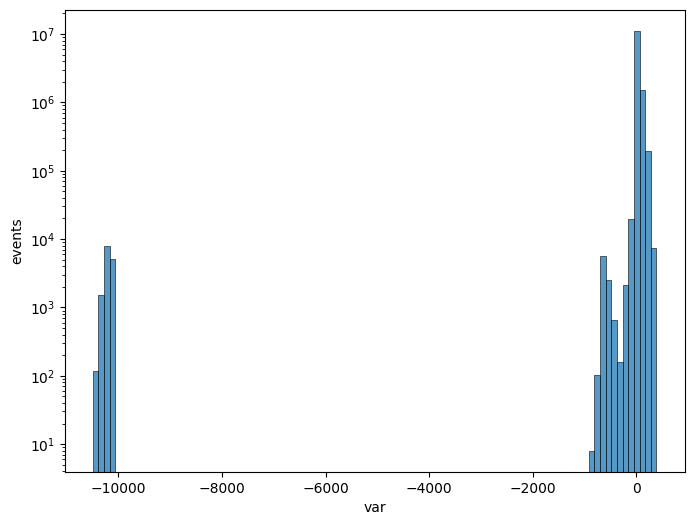

In [7]:
plt.figure(figsize=(8,6))
sn.histplot(time_residual.cpu(), bins = 100)
plt.xlabel('var')
plt.ylabel('events')
plt.yscale('log')

In [9]:
time_residual

array([   3.83100239,   42.11361182,    4.48512906, ...,  177.35358081,
        156.26340828, -603.61997274])

# 3 - Extract Valid Data

## 3.1 - Extract Index of valids PMT Type

In [18]:
## Numpy proofs to validate pytorch tools

valid_pmt_id = np.array(np.where(pmt_type == 1)[0], dtype = np.int16)  # PMT valid ID match with index of where pmt_type=1

valid_id_info_ev_i = np.array(np.where(np.in1d(hit_pmtid, valid_pmt_id))[0], dtype = np.int32)
valid_id_info_ev_i

array([   1,    2,    3, ..., 9693, 9694, 9695], dtype=int16)

## 3.2 - Extract valid info of EV

Use numpy type because Concatenates Faster!

In [ ]:
# With valid index data extract valid data

data_portion = 1   # percentage of data
lim_data = round(len(valid_id_info_ev_i)*data_portion)

multi_time_residual = []
multi_pmt_id_hit = []
multi_mc_momentum = []   #PENSAR BIEN COMO EXTRAER -> Se repite dentro de cada EV muchas veces -> Separar por evIDs
multi_xyz_hit = []

for valid_i in valid_id_info_ev_i[0:lim_data]:
    multi_time_residual.append(time_residual[valid_i])
    multi_mc_momentum.append(mc_momentum[valid_i])
    multi_pmt_id_hit.append(hit_pmtid[valid_i])
    
multi_time_residual = np.array(multi_time_residual, dtype = np.float16)   #Has to be an array to use numpoy tools bellow!

#extract xyz_hit from pmt_id_hit
for id_i in multi_pmt_id_hit:
    multi_xyz_hit.append(pmt_pos_xyz[id_i])

In [11]:
len(multi_xyz_hit) == len(multi_mc_momentum)

True

### 3.2.3 - Construct Observable $cos(α)$

In [12]:
multi_cos_angle = []
N = np.shape(multi_xyz_hit)[0]

for k in range(N):
    cos_val = np.dot(multi_xyz_hit[k], multi_mc_momentum[k])/(np.linalg.norm(multi_mc_momentum[k])*np.linalg.norm(multi_xyz_hit[k]))
    multi_cos_angle.append(cos_val)
multi_cos_angle = np.array(multi_cos_angle)

In [23]:
cos_val

-0.7969589859059613

# 4 - Plots

## 4.1 - Time residual vs. $cos(α)$

### 4.1.1 - cut time residual

In [13]:
up_cut = 20
inf_cut = -5

multi_time_res_cut = []
multi_cos_angle_cut = []

for i in np.where((multi_time_residual > inf_cut) & (multi_time_residual < up_cut))[0]:

    multi_time_res_cut.append(multi_time_residual[i])
    multi_cos_angle_cut.append(multi_cos_angle[i])

In [18]:
%matplotlib
# 2d Histogram
title = 'cos(α) - Multiple evID - 5MeV - random dir.'

bins = 40
plt.figure(figsize=(10,8))
#sn.set_style(rc = {'axes.facecolor': 'black'})
plt.hist2d(x = multi_cos_angle_cut, y = multi_time_res_cut, bins = [bins,bins], cmap = cm.nipy_spectral)
plt.colorbar()
plt.ylabel('time residual')
plt.xlabel('cos(α)')
plt.title(title)

#equal acis ration
#ax = plt.gca()
#ax.set_aspect('equal', adjustable='box')
plt.show()
#plt.savefig('figs/High Stat/' + title + '.png', format = 'png')

Using matplotlib backend: TkAgg


### 4.1.2 - Normalization

In [26]:
#Transforma Data into an Image Matrix

H, xedges, yedges = np.histogram2d(x = multi_cos_angle_cut, y = multi_time_res_cut, bins = [bins, bins])

#Now recover the data axis representation of time residual vs cos(alpha)
left = np.min(multi_time_res_cut)
right = np.max(multi_time_res_cut)
bottom = np.min(multi_cos_angle_cut)
top = np.max(multi_cos_angle_cut)

#Titles
title = 'cos(α) - Multiple evID - 5MeV - random dir.'
ylabel = 'cos(α)'
xlabel = 'time residual'

plt.figure(figsize=(10,8))
plt.imshow(H, extent = [left, right, top, bottom], aspect="auto" ) #---> Here is our image as a Matrix Pixel
plt.title(title)
plt.ylabel(ylabel)
plt.xlabel(xlabel)
plt.colorbar()
#plt.savefig('figs/High Stat/' + title +'(imshow).png', format = 'png')

#### 4.1.2.1 - Normalization by Nhits

In [28]:
# sum of hits in each bin = sum over each column element of the matrix.
sum_hit = np.sum(H,axis=0)  

H_normalized1 = H / sum_hit

N1title = 'Normalization by NHits - Multiple evID - 5MeV - random dir.'

plt.figure(figsize=(10,8))
plt.imshow(H_normalized1, extent = [left, right, top, bottom], aspect="auto" )
plt.title(N1title)
plt.ylabel(ylabel)
plt.xlabel(xlabel)
plt.colorbar()
#plt.savefig('figs/High Stat/' + N1title +'.png', format = 'png')